In [0]:
import pandas as pd
import math 
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Dataset preperation

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
filename = "1.txt"
path = "/content/drive/My Drive/Gait_Analysis/AnderssonDataSet/Person001/"

df = pd.read_csv(path + filename, sep=";", names=['join','X','Y','Z'])

#print(df.head(22))

In [0]:
#Calculate the frame number

df['rownum'] = df.index
df['frame'] = df['rownum'].apply(lambda x: int(x/20))

df = df.drop(['rownum'], axis=1)

print(df.head())

              join         X         Y         Z  frame
0             Head -0.028451  0.795389  2.586351      0
1  Shoulder-Center -0.010079  0.636442  2.609512      0
2   Shoulder-Right  0.025927  0.485954  2.466846      0
3    Shoulder-Left  0.028159  0.302599  2.432657      0
4      Elbow-Right  0.076405  0.283133  2.377785      0


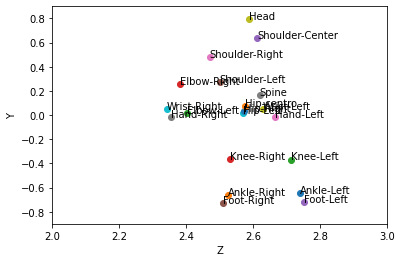

In [0]:
newdf = df.query('frame==10')
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
joins = newdf.groupby('join')
ax.axis([2,3,-0.9,0.9])

for name, join in joins:
    ax.scatter(join.Z, join.Y, label=name)
for name, join in joins:
    ax.annotate(name, (join.Z, join.Y))

ax.set_xlabel('Z')
ax.set_ylabel('Y')

plt.show()

In [0]:
dfmelt = df.melt(id_vars=['join','frame'], var_name='coord', value_name='coord_val')
print(dfmelt.head())

              join  frame coord  coord_val
0             Head      0     X  -0.028451
1  Shoulder-Center      0     X  -0.010079
2   Shoulder-Right      0     X   0.025927
3    Shoulder-Left      0     X   0.028159
4      Elbow-Right      0     X   0.076405


In [0]:
dfpivot = dfmelt.pivot_table(index='frame', columns=['join', 'coord'], values=['coord_val'])
dfpivot.columns = dfpivot.columns.droplevel()
#print(dfpivot.head())

In [0]:
#Laufendes Mittel 
for col in dfpivot.columns:
    dfpivot[col] = dfpivot[col].rolling(window=20).mean()

#Anzahl der Frames verringern
dfpivot = dfpivot.query('frame%1==0 & frame>0')

#print(dfpivot.head())

No handles with labels found to put in legend.


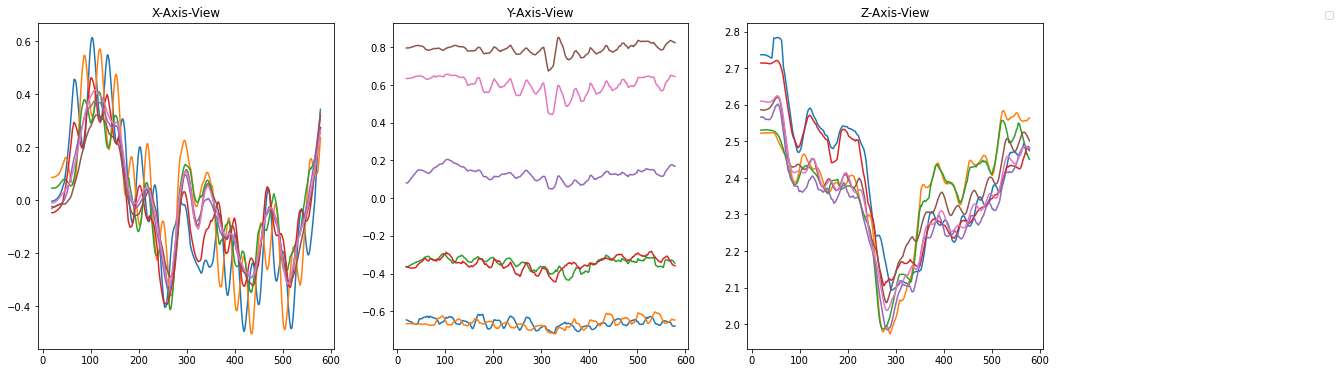

In [0]:
fig = plt.figure(figsize=(18,6))

coords = ['X', 'Y', 'Z']
joins = ['Ankle-Left','Ankle-Right','Knee-Right', 'Knee-Left','Hip-centro', 'Head','Shoulder-Center']

for i in range(3):
    ax = fig.add_subplot(1,3,(i+1))
    ax.set_title(coords[i] + "-Axis-View")
    for join in joins:
        ax.plot(dfpivot[join, coords[i]])

plt.legend(bbox_to_anchor=(2, 1.05))
plt.show()

# Feature-Extraktion

## Antropometric Features
### Nach Araujo 2013
![image.png](attachment:image.png)

### Weitere Features werden von Gianaria und Grangetto (2019) definiert
<img src="attachment:image.png" alt="Drawing" style="width: 500px;"/>

            L arm       R arm       torso       R leg       L leg      height
count  560.000000  560.000000  560.000000  560.000000  560.000000  560.000000
mean     0.975265    0.990190    1.373012    1.241456    1.246610    2.617045
std      0.051003    0.032915    0.018831    0.024355    0.023966    0.023340
min      0.756829    0.837413    1.327378    1.181924    1.179870    2.523110
25%      0.940140    0.974295    1.361611    1.224737    1.235770    2.606039
50%      0.962981    0.984845    1.371962    1.242489    1.244647    2.619997
75%      1.019206    1.016920    1.383527    1.257947    1.256766    2.630609
max      1.062098    1.046976    1.450711    1.298897    1.338481    2.692325


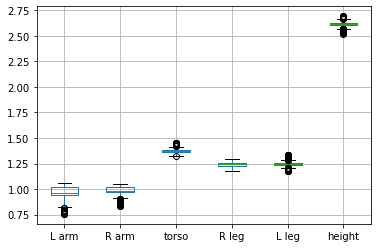

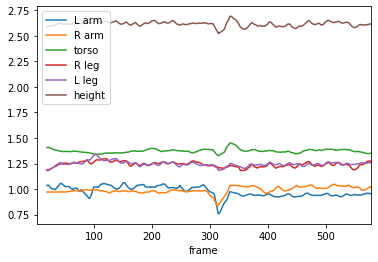

In [0]:
def body_part_length(joins):
    """v1: Liste, die die Join-Koordinaten in der Form Liste(X,Y,Z) 
        in der Reihenenfolge der Verknüpfung enthält"""
    body_part_length = 0
    for i in range(len(joins)-1):
        dist_between_joins = (
                                ((joins[i][0] - joins[i+1][0]) ** 2) +
                                ((joins[i][1] - joins[i+1][1]) ** 2) +
                                ((joins[i][2] - joins[i+1][2]) ** 2)
                            )**(1/(len(joins[i])+1))
        body_part_length += dist_between_joins
    
    return body_part_length

df_af = pd.DataFrame()

df_af['L arm'] = dfpivot.apply(lambda x: body_part_length([x['Shoulder-Left'].tolist(), x['Elbow-Left'].tolist(), x['Wrist-Left'].tolist()]), axis=1)
df_af['R arm'] = dfpivot.apply(lambda x: body_part_length([x['Shoulder-Right'].tolist(), x['Elbow-Right'].tolist(), x['Wrist-Right'].tolist()]), axis=1)

df_af['torso'] = dfpivot.apply(lambda x: body_part_length([x['Hip-centro'].tolist(), x['Spine'].tolist(), x['Shoulder-Center'].tolist(), x['Head'].tolist()]), axis=1)

df_af['R leg'] = dfpivot.apply(lambda x: body_part_length([x['Hip-Right'].tolist(), x['Knee-Right'].tolist(), x['Ankle-Right'].tolist()]), axis=1)
df_af['L leg'] = dfpivot.apply(lambda x: body_part_length([x['Hip-Left'].tolist(), x['Knee-Left'].tolist(), x['Ankle-Left'].tolist()]), axis=1)

df_af['height'] = df_af['torso'] + ((df_af['R leg'] + df_af['L leg'])/2)

print(df_af.describe())


df_af.boxplot()

df_af.plot()

## Nach Yang et al. (2016)
![image.png](attachment:image.png)
![Anmerkung%202020-03-21%20152946.png](attachment:Anmerkung%202020-03-21%20152946.png)
![Anmerkung%202020-03-21%20162001.png](attachment:Anmerkung%202020-03-21%20162001.png)

In [0]:
neu = pd.DataFrame()

neu['Dx1'] = abs(dfpivot['Ankle-Left']['X']-dfpivot['Ankle-Right']['X'])
neu['Dx2'] = abs(dfpivot['Elbow-Left']['X']-dfpivot['Elbow-Right']['X'])
neu['Dx3'] = abs(dfpivot['Hand-Left']['X']-dfpivot['Hand-Right']['X'])
neu['Dx4'] = abs(dfpivot['Head']['X']-((dfpivot['Ankle-Left']['X']+dfpivot['Ankle-Right']['X'])/2))
neu['Dx5'] = abs(dfpivot['Spine']['X']-((dfpivot['Ankle-Left']['X']+dfpivot['Ankle-Right']['X'])/2))
neu['Dx6'] = abs(dfpivot['Wrist-Left']['X']-dfpivot['Wrist-Right']['X'])
neu['Dx7'] = abs(dfpivot['Shoulder-Left']['X']-dfpivot['Shoulder-Right']['X'])

neu['Dy1'] = abs(dfpivot['Head']['Y']-((dfpivot['Foot-Left']['Y']+dfpivot['Foot-Right']['Y'])/2))
neu['Dy2'] = abs(dfpivot['Head']['Y']-((dfpivot['Knee-Left']['Y']+dfpivot['Knee-Right']['Y'])/2))
neu['Dy3'] = abs(dfpivot['Foot-Left']['Y']-dfpivot['Foot-Right']['Y'])

neu['Dz1'] = abs(dfpivot['Hand-Left']['Z']-dfpivot['Hand-Right']['Z'])



No handles with labels found to put in legend.


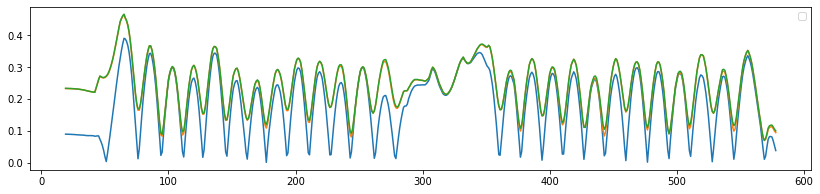

In [0]:
def dist(v1, v2):
    return math.sqrt(sum([(a - b) ** 2 for a, b in zip(v1, v2)]))

neu['Dxz1'] = dfpivot.apply(lambda x: dist(x['Ankle-Left'].tolist()[0::2],x['Ankle-Right'].tolist()[0::2]), axis=1)
neu['Dxyz1'] = dfpivot.apply(lambda x: dist(x['Ankle-Left'].tolist(),x['Ankle-Right'].tolist()), axis=1)

fig = plt.figure(figsize=(14,3))

ax = fig.add_subplot(1,1,1)
ax.plot(neu['Dx1'])
ax.plot(neu['Dxz1'])
ax.plot(neu['Dxyz1'])
plt.legend()
plt.show()

# --> 1-dimensionale Betrachtung hat höhere Schwankungen

No handles with labels found to put in legend.


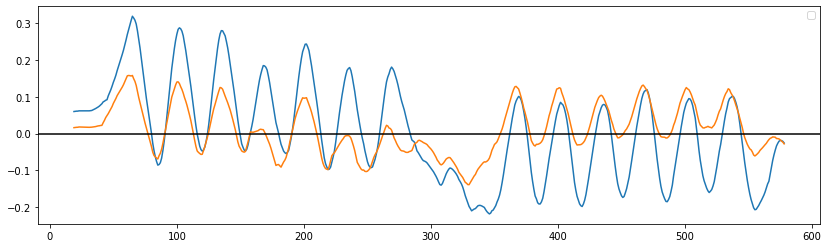

In [0]:
neu['Linker Fuß zu Oberkörper X'] = (dfpivot['Ankle-Left']['X']-dfpivot['Hip-Left']['X'])
neu['Linkes Knie zu Oberkörper X'] = (dfpivot['Knee-Left']['X']-dfpivot['Hip-Left']['X'])
neu['Rechter Fuß zu Oberkörper X'] = (dfpivot['Ankle-Right']['X']-dfpivot['Hip-Right']['X'])

fig = plt.figure(figsize=(14,4))
plt.plot(neu['Linker Fuß zu Oberkörper X'])
plt.plot(neu['Linkes Knie zu Oberkörper X'])
#plt.plot(neu['Rechter Fuß zu Oberkörper X'])
plt.axhline(y=0, color='k')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
No handles with labels found to put in legend.


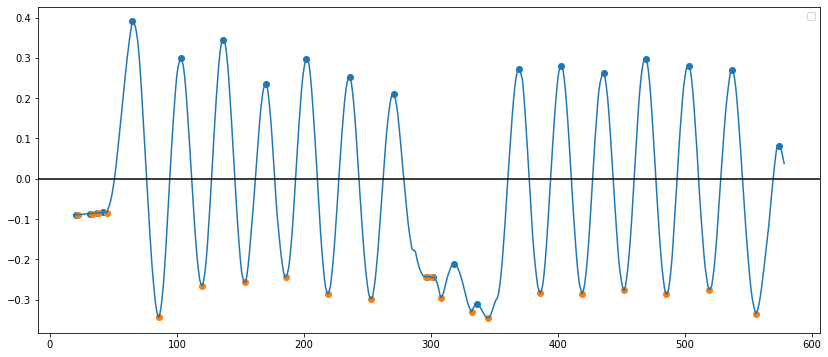

In [0]:
# Kennzahl ohne abs() kann zeigen, ob Schritt mit rechts oder links
neu['Dx1_total'] = (dfpivot['Ankle-Left']['X']-dfpivot['Ankle-Right']['X'])

# Bestimmung der lokalen Maxima / Minima
neu['Dx1_min'] = neu.Dx1_total[(neu.Dx1_total.shift(1) > neu.Dx1_total) & (neu.Dx1_total.shift(-1) > neu.Dx1_total)]
neu['Dx1_max'] = neu.Dx1_total[(neu.Dx1_total.shift(1) < neu.Dx1_total) & (neu.Dx1_total.shift(-1) < neu.Dx1_total)]

# Zeichnen des Graphs
fig = plt.figure(figsize=(14,6))

ax = fig.add_subplot(1,1,1)
ax.plot(neu['Dx1_total'])

ax = fig.add_subplot(1,1,1)
ax.scatter(neu.index, neu['Dx1_max'])

ax = fig.add_subplot(1,1,1)
ax.scatter(neu.index, neu['Dx1_min'])

ax.legend()
ax.axhline(y=0, color='k')

plt.show()

# --> Potentieller Ansatz zur Datenbreinigung: Wenn HP < 0, dann rausnehmen

In [0]:
my_iterator = neu.iterrows()

last_first_correct = 0
last_last_correct = 0
array_start = False

gait_cycles = []

for index, row in my_iterator:
    if not(pd.isna(row['Dx1_max'])): #Nur Hochpunkte betrachten
        #print(index, '\t', row['Dx1_max'], '\t', 'Array_start:', array_start, '\t', 'last_first_correct:', last_first_correct)
        if row['Dx1_max'] > 0 and not(array_start):
            last_first_correct = index
            array_start = True
        elif row['Dx1_max'] > 0:
            last_last_correct = index
        elif row['Dx1_max'] < 0 and array_start:
            gait_cycles.append(neu[last_first_correct-1:last_last_correct + 1].reset_index()) 
            array_start = False

# Die Liste gait_cycles enthält nun alle identifizierten Gangzyklen

# Mögliche Verbesserungen
## Nicht nur HP, sondern auch TP mit betrachten (da werden momentan noch mehr als notwendig rausgelassen)
## Weitere Kriterien einführen (TP > 0 wäre bspw. denkbar)

## Problem!
Wenn Patient z.B. sein Bein nachzieht, sind die HP ggf. immer < 0 !

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
No handles with labels found to put in legend.


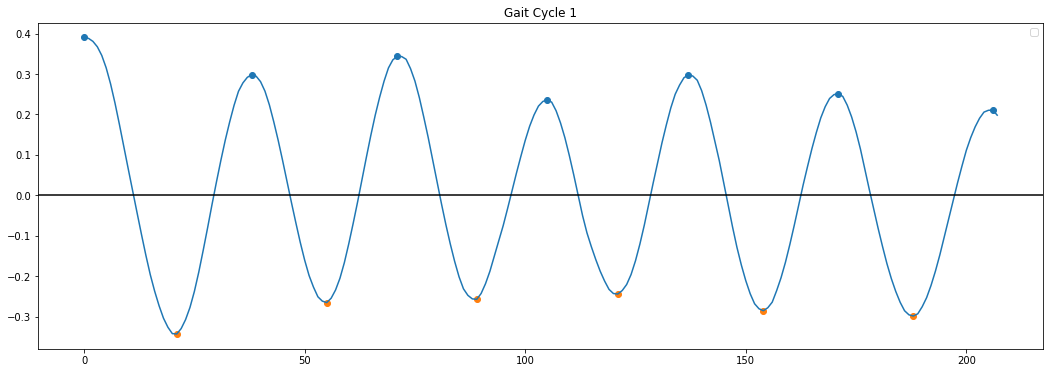

In [0]:
# Zeichnen des Graphs
fig = plt.figure(figsize=(18,6))

for i in range(len(gait_cycles)):
    ax = fig.add_subplot(1,len(gait_cycles),i+1)
    ax.plot(gait_cycles[i]['Dx1_total'])

    ax = fig.add_subplot(1,len(gait_cycles),i+1)
    ax.scatter(gait_cycles[i].index, gait_cycles[i]['Dx1_max'])

    ax = fig.add_subplot(1,len(gait_cycles),i+1)
    ax.scatter(gait_cycles[i].index, gait_cycles[i]['Dx1_min'])

    ax.legend()
    ax.set_title('Gait Cycle ' + str(i+1))
    ax.axhline(y=0, color='k')

plt.show()

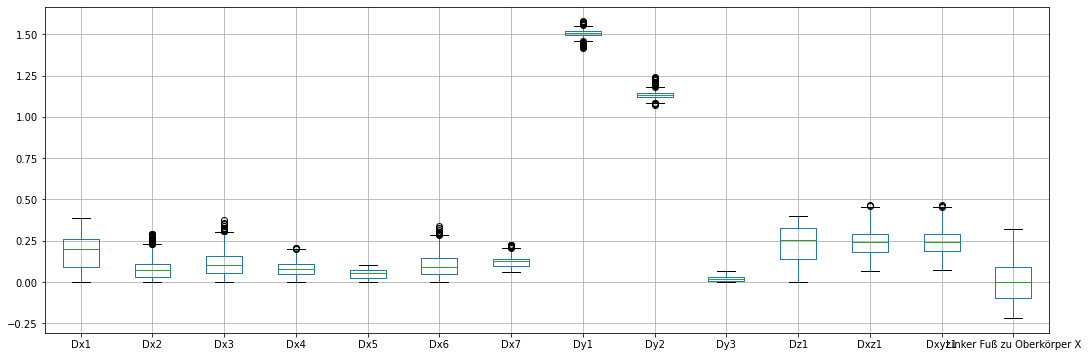

In [0]:
#for col in neu.columns:
#    print(col, '\tmean:', neu[col].mean(),  '\tmedian:', neu[col].median(),  '\tStd:', neu[col].std())

fig = plt.figure(figsize=(18, 6))
fig = neu.iloc[:,0:14].boxplot()

### Angles
#### Based on Andersson and Araujo (2015) 
As shown in Figure 1 (b), the angle θ is formed during a gait cycle between the segments of the thigh and a projection of the hip. Between the leg and the knee projection the angle γ is defined; α is the angle of the ankle rotation formed by the foot segment and the ankle projection and the foot angle β is formed by the opening of the foot in relation to the axis of the heel. These angles describe periodic curves during a walk, which can have useful characteristics for biometric recognition (Harrap 1956).

![image.png](attachment:image.png)

In [0]:
from math import degrees

def angle(v1,v2):
    if len(v1) == len(v2) == 2:
        gegenkathete = (v1[0]-v2[0])
        ankathete = (v1[1]-v2[1])
        result = np.tan(gegenkathete/ankathete)
    else:
        result = 0
    return degrees(result)
    

neu['theta_left'] = dfpivot.apply(lambda x: (angle(x['Hip-Left'][0:2].tolist(),x['Knee-Left'][0:2].tolist())), axis=1)
neu['gamma_left'] = dfpivot.apply(lambda x: (angle(x['Knee-Left'][0:2].tolist(),x['Ankle-Left'][0:2].tolist())), axis=1)

#neu['theta_right'] = dfpivot.apply(lambda x: angle(x['Hip-Right'].tolist(),x['Knee-Right'].tolist()), axis=1)
#neu['gamma_right'] = dfpivot.apply(lambda x: angle(x['Knee-Right'].tolist(),x['Ankle-Right'].tolist()), axis=1)


#print(neu.iloc[20::, :].head())

No handles with labels found to put in legend.
No handles with labels found to put in legend.


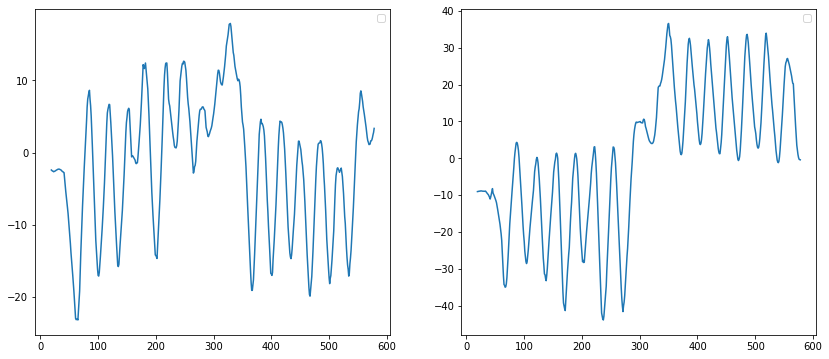

In [0]:
fig = plt.figure(figsize=(14,6))

ax = fig.add_subplot(1,2,1)
ax.plot(neu['theta_left'])
#ax.plot(neu['theta_right'])
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.plot(neu['gamma_left'])
#ax.plot(neu['gamma_right'])
ax.legend()

plt.show()